In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Define Accuracy Calculation Function

def calculate_monthly_accuracy(df, date_col, y_actual_col, y_pred_col):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['year_month'] = df[date_col].dt.to_period('M')

    monthly_accuracy = (
        df.groupby('year_month')
        .apply(lambda g: 1 - (np.abs(g[y_pred_col] - g[y_actual_col]).sum() / g[y_actual_col].sum()))
        .reset_index(name='Monthly_Accuracy')
    )
    return monthly_accuracy

In [3]:
# Load the CLEANED Dataset

data = pd.read_csv('cleaned_weekly_data.csv')

# Convert the 'date' column back to datetime objects
data['date'] = pd.to_datetime(data['date'])

In [4]:
# Prepare Data for Machine Learning Models

data_ml = data.copy()

# Feature Engineering (Lags and Rolling Stats)
lags = 7
for i in range(1, lags + 1):
    data_ml[f'lag_{i}'] = data_ml['quantity'].shift(i)

window_sizes = [4, 8]
for window in window_sizes:
    data_ml[f'rolling_mean_{window}'] = data_ml['quantity'].shift(1).rolling(window=window).mean()
    data_ml[f'rolling_median_{window}'] = data_ml['quantity'].shift(1).rolling(window=window).median()

# Time-based features
data_ml['year'] = data_ml['date'].dt.year
data_ml['month'] = data_ml['date'].dt.month
data_ml.dropna(inplace=True)

In [5]:
# Split Data into Training and Testing Sets
# Training data is up to May 2024. Test data is June, July, August 2024.

train = data[data['date'] <= '2024-05-31'].copy()
test = data[data['date'] > '2024-05-31'].copy()

train_ml = data_ml[data_ml['date'] <= '2024-05-31'].copy()
test_ml = data_ml[data_ml['date'] > '2024-05-31'].copy()

# Create a DataFrame to store predictions
predictions = pd.DataFrame({'date': test['date'], 'quantity': test['quantity']}).reset_index(drop=True)

In [6]:
# Train and Evaluate Machine Learning Models

features = [col for col in data_ml.columns if col not in ['date', 'quantity']]
target = 'quantity'

X_train = train_ml[features]
y_train = train_ml[target]
X_test = test_ml[features]
y_test = test_ml[target]

models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

print("--- Training Machine Learning Models ---")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)


--- Training Machine Learning Models ---
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...


In [7]:
# Train and Evaluate Tuned Time Series Models
print("\\n--- Training Tuned Time Series Models ---")

# Tuned SARIMA Model (with yearly seasonality m=52)
print("Training Tuned SARIMA model...")
sarima_model_tuned = SARIMAX(train['quantity'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 52)).fit(disp=False)
predictions['SARIMA_tuned'] = sarima_model_tuned.predict(start=len(train), end=len(train)+len(test)-1).reset_index(drop=True)
print("Tuned SARIMA training complete.")

# Tuned Prophet Model (with yearly seasonality enabled)
print("\\nTraining Tuned Prophet model...")
data_prophet = train.rename(columns={'date': 'ds', 'quantity': 'y'})
prophet_model_tuned = Prophet(yearly_seasonality=True)
prophet_model_tuned.fit(data_prophet)
future_tuned = prophet_model_tuned.make_future_dataframe(periods=len(test), freq='W-SAT')
forecast_tuned = prophet_model_tuned.predict(future_tuned)
predictions['Prophet_tuned'] = forecast_tuned.tail(len(test))['yhat'].reset_index(drop=True)
print("Tuned Prophet training complete.")

\n--- Training Tuned Time Series Models ---
Training Tuned SARIMA model...
Tuned SARIMA training complete.
\nTraining Tuned Prophet model...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd83h16h0/svuoht84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd83h16h0/5si9shoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40525', 'data', 'file=/tmp/tmpd83h16h0/svuoht84.json', 'init=/tmp/tmpd83h16h0/5si9shoc.json', 'output', 'file=/tmp/tmpd83h16h0/prophet_modelzhszqrtj/prophet_model-20250903071956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Tuned Prophet training complete.


In [8]:
# Create and Evaluate Ensemble Model

print("\\n--- Creating and Evaluating Ensemble Model ---")
predictions['Combined_tuned'] = 0.5 * predictions['SARIMA_tuned'] + 0.5 * predictions['Prophet_tuned']

# Calculate accuracy for all models
Accuracy_Table = pd.DataFrame()
cols_to_evaluate = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'SARIMA_tuned', 'Prophet_tuned', 'Combined_tuned']
for col in cols_to_evaluate:
    monthly_accuracy = calculate_monthly_accuracy(predictions, 'date', 'quantity', col)
    Accuracy_Table[col] = monthly_accuracy['Monthly_Accuracy']

Accuracy_Table.index = monthly_accuracy['year_month']

print("\\n--- Monthly Accuracy Table (June-August 2024) ---")
print(Accuracy_Table)

print("\\n--- Average Accuracy (June-August 2024) ---")
print(Accuracy_Table.mean().sort_values(ascending=False))

\n--- Creating and Evaluating Ensemble Model ---
\n--- Monthly Accuracy Table (June-August 2024) ---
            Random Forest  Gradient Boosting   XGBoost  SARIMA_tuned  \
year_month                                                             
2024-06          0.520101           0.553242  0.629480      0.403312   
2024-07          0.539252           0.601952  0.546719      0.442004   
2024-08          0.608227           0.753512  0.593063     -0.697899   

            Prophet_tuned  Combined_tuned  
year_month                                 
2024-06          0.379517        0.391414  
2024-07          0.619866        0.530935  
2024-08         -0.205980       -0.451939  
\n--- Average Accuracy (June-August 2024) ---
Gradient Boosting    0.636235
XGBoost              0.589754
Random Forest        0.555860
Prophet_tuned        0.264468
Combined_tuned       0.156803
SARIMA_tuned         0.049139
dtype: float64


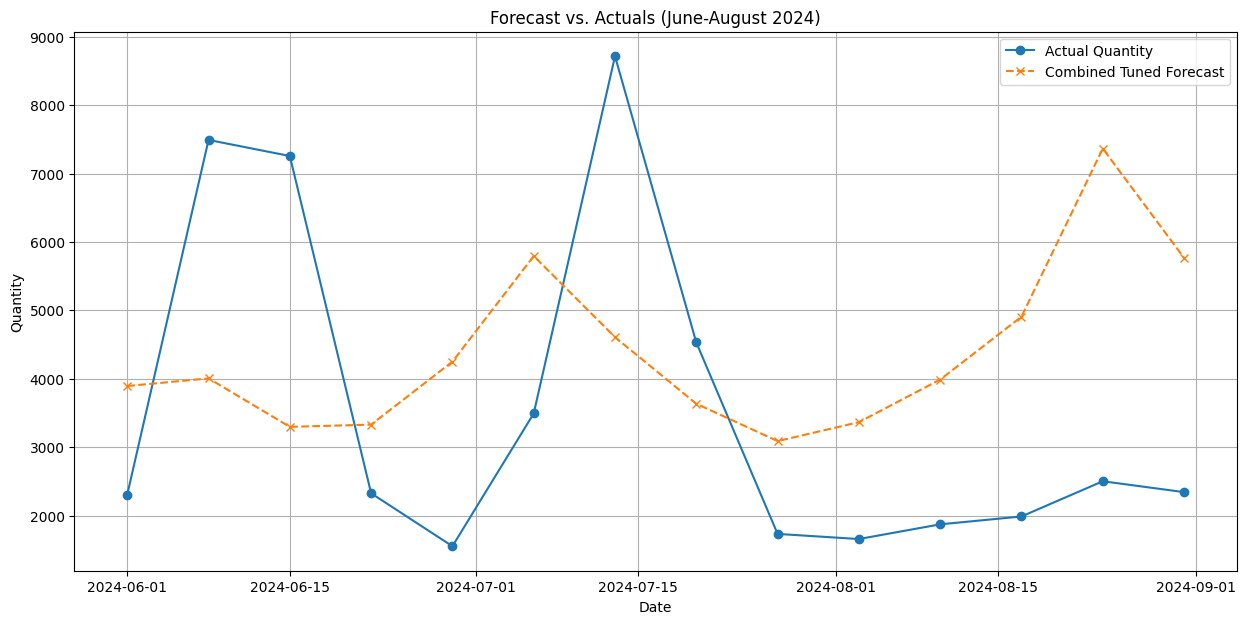

In [9]:
# Plot Best Model vs. Actuals

plt.figure(figsize=(15, 7))
plt.plot(predictions['date'], predictions['quantity'], label='Actual Quantity', marker='o')
plt.plot(predictions['date'], predictions['Combined_tuned'], label='Combined Tuned Forecast', marker='x', linestyle='--')
plt.title('Forecast vs. Actuals (June-August 2024)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Final Forecast for Sep, Oct, Nov 2024

print("\\n--- Generating Final Forecast for Sep, Oct, Nov 2024 ---")

# Retrain models on the FULL dataset
print("Retraining SARIMA on all data...")
final_sarima_model = SARIMAX(data['quantity'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 52)).fit(disp=False)

print("Retraining Prophet on all data...")
final_prophet_data = data.rename(columns={'date': 'ds', 'quantity': 'y'})
final_prophet_model = Prophet(yearly_seasonality=True)
final_prophet_model.fit(final_prophet_data)

# Create future dates for forecasting
future_dates_df = final_prophet_model.make_future_dataframe(periods=13, freq='W-SAT') # 13 weeks for Sep, Oct, Nov

# Generate forecasts
print("Forecasting future values...")
sarima_forecast = final_sarima_model.forecast(steps=13).reset_index(drop=True)
prophet_forecast = final_prophet_model.predict(future_dates_df)
prophet_pred = prophet_forecast.tail(13)['yhat'].reset_index(drop=True)

# Create the final predictions DataFrame
final_predictions = pd.DataFrame({
    'date': future_dates_df.tail(13)['ds'].reset_index(drop=True),
    'SARIMA_Forecast': sarima_forecast,
    'Prophet_Forecast': prophet_pred
})

# Create the final combined forecast
final_predictions['Combined_Forecast'] = 0.5 * final_predictions['SARIMA_Forecast'] + 0.5 * final_predictions['Prophet_Forecast']

print("\\n--- Final Forecasted Weekly Quantities ---")
print(final_predictions)

\n--- Generating Final Forecast for Sep, Oct, Nov 2024 ---
Retraining SARIMA on all data...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd83h16h0/_bu1v0gl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd83h16h0/i0cydg9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67160', 'data', 'file=/tmp/tmpd83h16h0/_bu1v0gl.json', 'init=/tmp/tmpd83h16h0/i0cydg9p.json', 'output', 'file=/tmp/tmpd83h16h0/prophet_modeltyh33k2a/prophet_model-20250903072050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Retraining Prophet on all data...
Forecasting future values...
\n--- Final Forecasted Weekly Quantities ---
         date  SARIMA_Forecast  Prophet_Forecast  Combined_Forecast
0  2024-09-07      6408.801226       6197.965876        6303.383551
1  2024-09-14      4836.521695       6849.917713        5843.219704
2  2024-09-21      5263.959974       6519.105222        5891.532598
3  2024-09-28      3626.712238       5119.433659        4373.072949
4  2024-10-05      3399.852226       3562.010127        3480.931176
5  2024-10-12      2767.000439       2944.214569        2855.607504
6  2024-10-19      2971.649065       3411.688640        3191.668853
7  2024-10-26      3377.080174       4050.911985        3713.996079
8  2024-11-02      3415.456318       3967.643030        3691.549674
9  2024-11-09      2658.117849       3287.053770        2972.585809
10 2024-11-16      2791.234150       2925.784946        2858.509548
11 2024-11-23      3468.391347       3468.538498        3468.464923
12 2024-

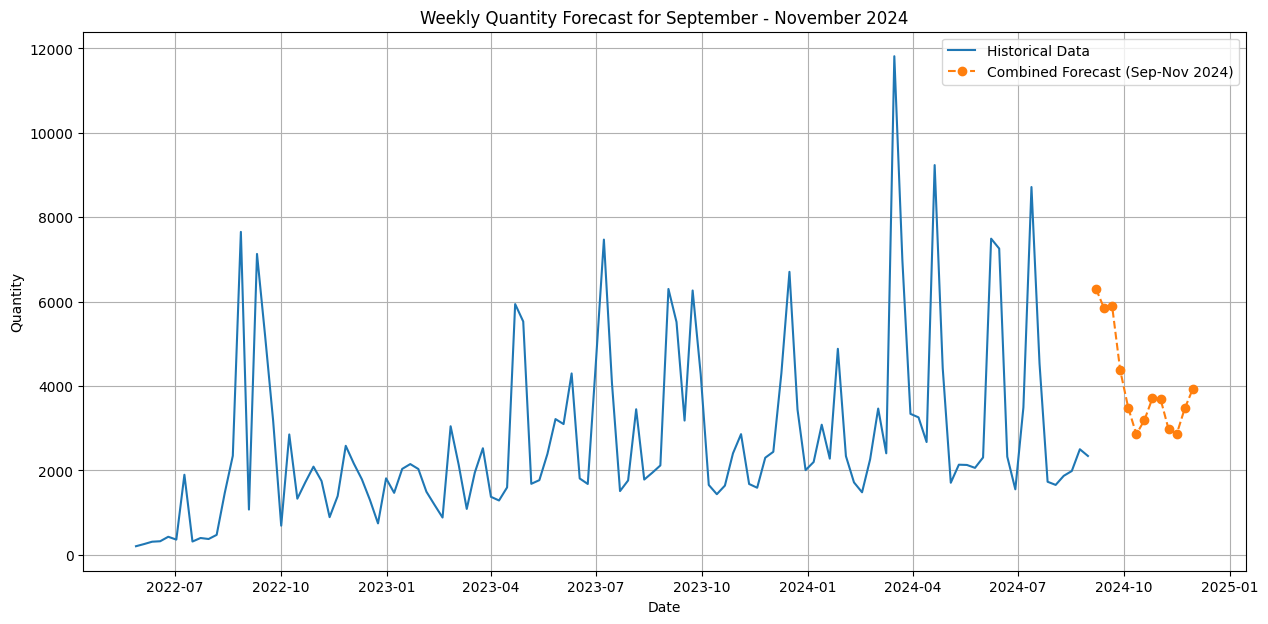

In [11]:
# Plot the Final Forecast
plt.figure(figsize=(15, 7))
plt.plot(data['date'], data['quantity'], label='Historical Data')
plt.plot(final_predictions['date'], final_predictions['Combined_Forecast'], label='Combined Forecast (Sep-Nov 2024)', linestyle='--', marker='o')
plt.title('Weekly Quantity Forecast for September - November 2024')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Save the final forecast to an Excel file
final_predictions.to_excel('weekly_quantity_forecast.xlsx', index=False)
print("\\nFinal forecast saved to 'weekly_quantity_forecast.xlsx'")

\nFinal forecast saved to 'weekly_quantity_forecast.xlsx'
